# Mosaic (so I can have it in the same dir as the photos)

['3.jpg', '5.jpg', '4.jpg', '2.jpg', '1.jpg']


AttributeError: 'tuple' object has no attribute 'queryIdx'

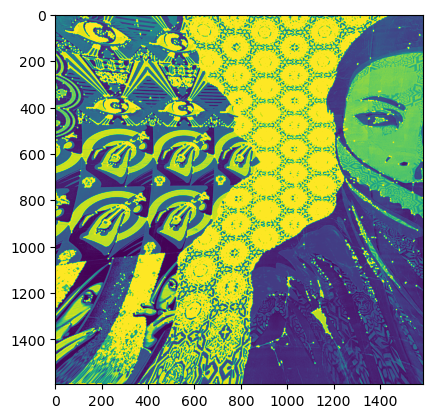

In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob

# Load Calibration Parameters:
cfs = ("camera.npy", "distortion.npy")

def load_calibration(calibration_file):#     Function load_calibration(calibration_file):
    '''
    Loads camera calibration data from list of calibration files.
    '''
    cam = np.load(calibration_file[0])
    dis = np.load(calibration_file[1])#         Load calibration data from the file         
    # Extract camera matrix and distortion coefficients
    return (cam, dis)#Return camera matrix and distortion coefficients

# Undistort Image:
def undistort_image(image, camera_matrix, dist_coeffs):#     Function undistort_image(image, camera_matrix, dist_coeffs):
    '''
    Undistorts image given the image, camera matrix, and distortion coefficients.
    '''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = image.shape#         Get image dimensions (height, width)
    newcam, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (width, height), 1, (width, height))#         Compute new camera matrix for undistortion
    udist = cv2.undistort(image, camera_matrix, dist_coeffs, None, newcam)#         Undistort the image (use cv2 undistort)
    rx, ry, rw, rh = roi
    udcrop = udist[ry: ry+rh, rx: rx+rw]#         Crop the undistorted image using ROI
    return(udcrop)#         Return undistorted image

# Harris Corner Detection:
def harris_corner_detection(image):#     Function harris_corner_detection(image):
    '''
    Applies harris corner detection to images
    '''
    #prevent the function from trying to convert a grayscale image to grayscale
    if len(image.shape) == 2:
        imG = image
    else:    
        imG = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)#         Convert the image to grayscale
    
    iMg = np.float32(imG)# convert to float32 for some reason
    
    hare= cv2.cornerHarris(iMg, 2, 3, 0.04)#         Apply Harris corner detection
    pupil = cv2.dilate(hare, None)#         Dilate corners
    
    # Mark corners on the image
    wall = 0.01 * pupil.max()
    Img = image.copy()
    waldo = np.where(pupil > wall)
    for y, x in zip(*waldo):
        cv2.circle(Img, (x, y), 2, (255, 255, 255), -1)
    plt.imshow(Img)
    return (Img, waldo)#Return image with marked corners and detected corners

# Match Features Between Images:
def match_features(image1, image2):#     Function match_features(image1, image2):
    '''
    Matches features between two given images
    '''
    
    sif = cv2.SIFT_create()
    k1, d1 = sif.detectAndCompute(image1, None)#         Detect keypoints and descriptors in image1 using SIFT
    k2, d2 = sif.detectAndCompute(image2, None)#         Detect keypoints and descriptors in image2 using SIFT
    ogre = cv2.BFMatcher()
    mat = ogre.knnMatch(d1, d2, k = 2) #         Match descriptors using brute-force matcher
    
    #        Extract matched points from both images
    sp = []
    dp = []

    
    for pat in mat:
        sp.append(np.float32(k1[pat.queryIdx].pt))
        dp.append(np.float32(k2[pat.trainIdx].pt))
    
    sp = np.array(sp)
    sp = sp.reshape(-1, 1, 2)
    dp = np.array(dp)
    dp = dp.reshape(-1, 1, 2)
    
    
    palpatine, senator = cv2.findHomography(sp, dp, cv2.RANSAC, 5.0)

    return (sp, dp, palpatine)#         Return matched points from image1 and image2

# Create Mosaic:
def create_mosaic(images, camera, dist_coeffs): #     Function create_mosaic(images, camera_matrix, dist_coeffs):
    '''
    Creates a mosaic from multaple images of the same object given the images, the camera matrix, and the distortion coefficients.
    '''
    
    ud_imags = []
    for pict in images:
        ud = undistort_image(pict, camera, dist_coeffs)
        ud_imags.append(ud)#         Undistort all images using undistort_image function
    mosaic = ud_imags[0].copy()#         Initialize mosaic with the first undistorted image
    mosaicw = mosaic.shape[1]
    mosaIc = (mosaic.shape[1])/2
    ud_imags.pop(0)
    for picts in ud_imags:#         For each subsequent undistorted image:
        wabbit, w4bbit = harris_corner_detection(picts) #             Detect Harris corners in both mosaic and current image using harris_corner_detection
        Ovid, Ov1d = harris_corner_detection(mosaic)
        sp1, dp1, homography = match_features(wabbit, Ovid)#             Match features between mosaic and current image using match_features
        # (above)            Estimate homography using matched points
        mosaicw += mosaIc
        mosaicd = (mosaicw, mosaic.shape[0])
        print(mosaicd)
        spock = cv2.warpPerspective(picts, homography, mosaicd)#             Warp moaic image using the estimated homography
        mosaic = cv2.addWeighted(mosaic, 0.5, spock, 0.5, 0)#             Blend current image into mosaic   
    return (mosaic)#         Return final mosaic image

# Main:
calibri = load_calibration(cfs)#     Load camera matrix and distortion coefficients from calibration file
globby1 = glob.glob("*.jpg")
newglob = []
print(globby1)
for globs1 in globby1:
    img1 = cv2.imread(globs1)
    newglob.append(img1) #     Load images from specified directory
globtup = tuple(newglob)
mosaic_image = create_mosaic(globtup, calibri[0], calibri[1])#   Create mosaic using create_mosaic function
#    TODO Save the mosaic image to a file

# # Display the mosaic image
plt.imshow('Mosaic', mosaic_image)